# Анализ музыки Spotify

Выполнил: Скрябин Д.С. 4941102/10701

Database: https://www.kaggle.com/datasets/geomack/spotifyclassification

Этот Notebook выполняет базовый анализ метаданных песен, взятых из Spotify. Данные содержат числовые показатели, сгенерированные Spotify, которые измеряют танцевальность песен, настроение, живость и т. д. Данные также содержат название песен и исполнителя.

Импортируем все необходимые модули и создадим таблицу для анализа.

In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

%matplotlib inline

data_frame = pd.read_csv("/content/SpotifyData.csv")
data_frame = data_frame.drop("Unnamed: 0", axis="columns")
data_frame.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


Cоздадим диаграмму рассеяния, основанную на значениях валентности и танцевальности песен. Кроме того, мы также будем использовать линейную регрессию, чтобы найти их корреляцию.

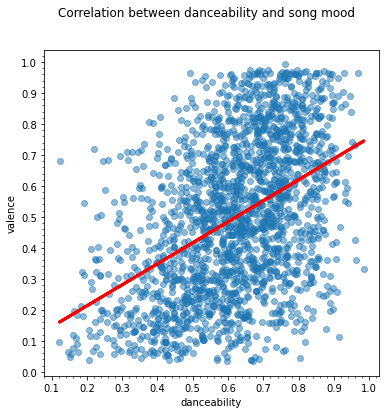

In [15]:
x = data_frame["danceability"].values
y = data_frame["valence"].values

x = x.reshape(x.shape[0], 1)
y = y.reshape(y.shape[0], 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

fig = plt.figure(figsize=(6, 6))
fig.suptitle("Correlation between danceability and song mood")

ax = plt.subplot(1, 1, 1)
ax.scatter(x, y, alpha=0.5)
ax.plot(x, regr.predict(x), color="red", linewidth=3)
plt.xticks(())
plt.yticks(())

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

plt.xlabel("danceability")
plt.ylabel("valence")

plt.show()

Создадим несколько гистограмм. График слева иллюстрирует распределение песен по уровню их энергии, тогда как правый график, представляет собой «тепловую карту» (гистограмму в двух измерениях), которая иллюстрирует количество песен, найденных при всех значениях валентности и танцевальности.

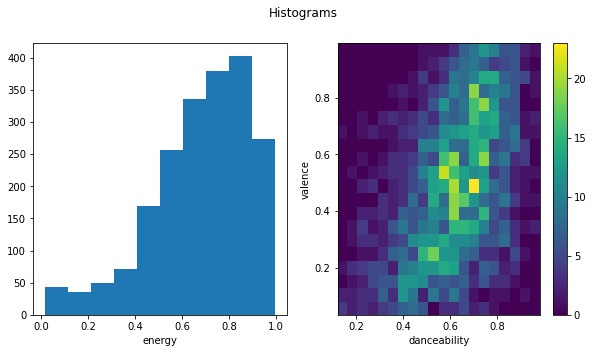

In [16]:
x = "danceability"
y = "valence"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(10, 5))
fig.suptitle("Histograms")
h = ax2.hist2d(data_frame[x], data_frame[y], bins=20)
ax1.hist(data_frame["energy"])

ax2.set_xlabel(x)
ax2.set_ylabel(y)

ax1.set_xlabel("energy")

plt.colorbar(h[3], ax=ax2)

plt.show()

Затем создадим список выбранных категорий и проанализируем основные компоненты, чтобы уменьшить размерность этого списка до 3, создавая матрицу, подходящую для создания трехмерного графика. Чем меньше расстояние между любыми двумя песнями, тем больше их сходства по категориям.

In [17]:
chosen = ["energy", "liveness", "tempo", "valence", "loudness", "speechiness", "acousticness", "danceability", "instrumentalness"]
text1 = data_frame["artist"] + " - " + data_frame["song_title"]
text2 = text1.values

# X = data_frame.drop(droppable, axis=1).values
X = data_frame[chosen].values
y = data_frame["danceability"].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=3)
pca.fit(X)

X = pca.transform(X)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

trace = go.Scatter3d(
    x=X[:,0],
    y=X[:,1],
    z=X[:,2],
    text=text2,
    mode="markers",
    marker=dict(
        size=8,
        color=y
    )
)

fig = go.Figure(data=[trace])
py.iplot(fig, filename="test-graph")

В другой реализации используем меньший список категорий и метод главных компонент для создания двумерного графика. Для того, чтобы передать смысл графика, взглянем на названия осей.

In [18]:
chosen = ["energy", "liveness", "tempo", "valence"]
text1 = data_frame["artist"] + " - " + data_frame["song_title"]
text2 = text1.values

# X = data_frame.drop(droppable, axis=1).values
X = data_frame[chosen].values
y = data_frame["loudness"].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X)

X = pca.transform(X)

fig = {
    "data": [
        {
            "x": X[:, 0],
            "y": X[:, 1],
            "text": text2,
            "mode": "markers",
            "marker": {"size": 8, "color": y}
        }
    ],
    "layout": {
        "xaxis": {"title": "How hard is this to dance to?"},
        "yaxis": {"title": "How metal is this?"}
    }
}

py.iplot(fig, filename="test-graph2")

Создадим еще один трехмерный график, используя алгоритм стохастического вложения соседей с t-распределением.

In [19]:
import time

chosen = ["energy", "liveness", "tempo", "valence", "loudness",
          "speechiness", "acousticness", "danceability", "instrumentalness"]

X = data_frame[chosen].values
y = data_frame["loudness"].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

fig = {
    "data": [
        {
            "x": tsne_results[:, 0],
            "y": tsne_results[:, 1],
            "text": text2,
            "mode": "markers",
            "marker": {"size": 8, "color": y}
        }
    ],
    "layout": {
        "xaxis": {"title": "x-tsne"},
        "yaxis": {"title": "y-tsne"}
    }
}

py.iplot(fig, filename="test-graph3")

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2017 samples in 0.020s...
[t-SNE] Computed neighbors for 2017 samples in 0.418s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2017
[t-SNE] Computed conditional probabilities for sample 2000 / 2017
[t-SNE] Computed conditional probabilities for sample 2017 / 2017
[t-SNE] Mean sigma: 0.145413
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.470390
[t-SNE] KL divergence after 300 iterations: 1.485609
t-SNE done! Time elapsed: 19.055029153823853 seconds
